In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import LBFGS

In [2]:

def exact_solution(nx, nt, D, L, T):
    x = np.linspace(0, L, nx, endpoint=False)
    t = np.linspace(0, T, nt + 1, endpoint=True)
    k = 2 * np.pi / L
    lam = k**2 * D
    u = np.exp(-lam * t[None, :]) * np.cos(k * x[:, None])
    return x, t, u


def generate_data(num_data, nx, nt, D, L, T, rng, sigma):
    x = np.linspace(0, L, nx, endpoint=False)
    t = np.linspace(0, T, nt + 1, endpoint=True)

    xd = rng.choice(x, num_data, replace=True)
    td = rng.choice(t, num_data, replace=True)

    k = 2 * np.pi / L
    lam = k**2 * D
    ud = np.exp(-lam * td) * np.cos(k * xd) + rng.normal(0, sigma, len(xd))

    return xd, td, ud


def loss_fun(u_):
    u = u_.reshape((nx, nt + 1))
    dudt = torch.diff(u, axis=1) / dt
    um = (u[:, :-1] + u[:, 1:]) / 2
    d2udx2 = (torch.roll(um, shifts=-1, dims=0) - 2 * um +
              torch.roll(um, shifts=1, dims=0)) / (dx**2)

    pde_res = dudt - D * d2udx2
    data_res = u[xd_ids_, td_ids_] - ud_

    pde_loss = torch.mean(pde_res**2)
    nlp = beta * pde_loss
    nlp += torch.sum(
        data_res**2 /
        (2 * sigma_data**2)) + num_data / 2 * np.log(2 * np.pi * sigma_data**2)
    return nlp


seed = 2349873
num_epochs = 500
lr = 5e-4
sigma_data = 0.1
beta = 1e4
rng = np.random.default_rng(seed=seed)
num_data = 200

T = 1.0
D = 0.1
L = 1.0

nx = 16
nt = 63

x, t, uexact = exact_solution(nx=nx, nt=nt, D=D, L=L, T=T)
xd, td, ud = generate_data(num_data=num_data,
                           nx=nx,
                           nt=nt,
                           D=D,
                           L=L,
                           T=T,
                           rng=rng,
                           sigma=sigma_data)

dx = x[1] - x[0]
dt = t[1] - t[0]

u_ = torch.zeros(nx * (nt + 1), requires_grad=True)
td_ids = (td / dt).astype(int)
xd_ids = (xd / dx).astype(int)

td_ids_ = torch.from_numpy(td_ids)
xd_ids_ = torch.from_numpy(xd_ids)
ud_ = torch.from_numpy(ud)
optim = LBFGS([u_], lr=lr)
losses = []
for epoch in range(num_epochs):

    def closure():
        optim.zero_grad()
        loss = loss_fun(u_)
        loss.backward()
        return loss

    optim.step(closure)
    if epoch % 100 == 0:
        l = loss_fun(u_).detach().item()
        print(f"epoch {epoch:06d}, loss {l:.6e}")

    losses.append(l)

u = u_.detach().numpy()
u = u.reshape((nx, (nt + 1)))

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


epoch 000000, loss 4.718059e+02
epoch 000100, loss -1.041522e+02
epoch 000200, loss -1.802952e+02
epoch 000300, loss -1.892868e+02
epoch 000400, loss -1.904364e+02


Text(0, 0.5, '$t/T$')

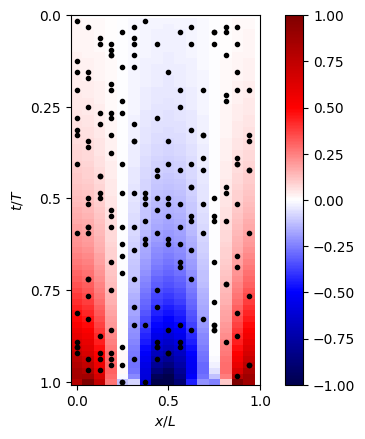

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(u.T,
               origin='lower',
               cmap="seismic",
               vmin=-1,
               vmax=1,
               aspect=2 * nx / (nt + 1))
fig.colorbar(im, ax=ax)
ax.plot(xd_ids, td_ids, '.k')
ax.set(xticks=np.linspace(0, nx, 3),
       xticklabels=np.linspace(0, L, 3),
       yticks=np.linspace(nt + 1, 0, 5),
       yticklabels=np.linspace(0, T, 5))
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$t/T$');
